# Primary analyses of our sequences

In [1]:
import os
import sys
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Define the data directory
data_dir = '/data'

### Checking out the reads

In [2]:
! qiime demux summarize \
  --i-data ./data/fungut_forward_reads.qza \
  --o-visualization ./data/fungut_forward_reads_summary.qzv

Saved Visualization to: ./data/fungut_forward_reads_summary.qzv


In [ ]:
Visualization.load('./data/fungut_forward_reads_summary.qzv')

#### As seen in the visualisation, the reads have very high quality up to a length of 150. Therefore we chose a truncation length of 150.

### Checking out the metadata

In [4]:
!qiime metadata tabulate \
  --m-input-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/fungut_metadata.qzv

Saved Visualization to: ./data/fungut_metadata.qzv


In [7]:
Visualization.load('./data/fungut_metadata.qzv')

<visualization: Visualization uuid: a8b7eebb-42c5-4d68-ac79-1a32d957e8ef>

## Preprocessing the metadata

### Removing rows with NaN for Diseases

In [69]:
#read metadata
metadata = pd.read_csv("./datafungut_metadata.tsv", sep="\t")

In [70]:
#count the rows that have column "ibd_sample" and "gluten_sample" = Not provided
filtered_rows = metadata[(metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided")]
print(len(filtered_rows), "samples have both response variables not provided")

#filter rows that have column "ibd_sample" and "gluten_sample" = Not provided
metadata = metadata[~((metadata['ibd_sample'] == "Not provided") & (metadata['gluten_sample'] == "Not provided"))]
metadata.describe()
print(len(filtered_rows), "samples have been removed")

4 samples have both response variables not provided
4 samples have been removed


### Removing rows with only NaN

In [71]:
# count the number of rows that have more than x columns not provided
for x in range(1, 6):
    count = metadata[metadata.eq("Not provided").sum(axis=1) >= x].shape[0]
    print(count, "samples have not provided", x, "columns")

62 samples have not provided 1 columns
10 samples have not provided 2 columns
5 samples have not provided 3 columns
2 samples have not provided 4 columns
1 samples have not provided 5 columns


now we have to decide which of them we want filter out

### Create new feature "Symptoms vs No-Symptoms"

In [72]:
metadata['gluten_sample'].unique()

array(['No',
       'I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease',
       'I do not eat gluten because it makes me feel bad',
       'I was diagnosed with celiac disease', 'Not provided'],
      dtype=object)

In [75]:
# Define the categories to summarize as "symptoms"
no_symptoms = ['I do not have this condition']  

# Create a new column with a binary classification
metadata['ibd_symptoms'] = metadata['ibd_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

In [77]:
# Define the categories to summarize as "no_symptoms"
no_symptoms = ['No']  

# Create a new column with a binary classification
metadata['gluten_symptoms'] = metadata['gluten_sample'].apply(
    lambda x: 'Not provided' if x == 'Not provided' else 
              ('no_symptoms' if x in no_symptoms else 'symptoms')
)

### Save processed metadata as tsv file

In [78]:
metadata.to_csv('./data/fungut_metadata_processed.tsv', sep='\t', index=False)

### Denoising with dada2
We chose a truncation length of 150 because...

In [ ]:
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs ./data/fungut_forward_reads.qza \
  --p-trim-left 0 \
  --p-trunc-len 150 \
  --o-representative-sequences ./data/rep-seqs.qza \
  --o-table ./data/feature-table.qza \
  --o-denoising-stats ./data/denoising-stats.qza

#### Check out the feature table

In [ ]:
!qiime feature-table summarize \
  --i-table ./data/feature-table.qza \
  --o-visualization ./data/feature-table-summary.qzv

In [ ]:
Visualization.load('./data/table-summary.qzv')

### Classification
This step was executed on Euler, as we ran into the problem of not having sufficient memory on JupyterHub
See our bash script we ran on Euler in './scripts/'

In [ ]:
'''
!qiime feature-classifier classify-sklearn \
  --i-classifier ./data/taxonomy_classification/unite_ver10_dynamic_s_all_04.04.2024-Q2-2024.5.qza \
  --i-reads ./data/rep-seqs.qza \
  --p-reads-per-batch 1000 \
  --o-classification ./taxonomy_unite_dynamic_s_all.qza
'''

In [6]:
# tabulation of the taxonomy classification only 99, so the too basic classifier, without eukaryotes
!qiime metadata tabulate \
  --m-input-file ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qza \
  --o-visualization ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv

Saved Visualization to: ./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv


In [ ]:
Visualization.load('./data/taxonomy_classification/taxonomy_unite_dynamic_s_all.qzv')

#### Create the taxonomy bar plot

In [ ]:
!qiime taxa barplot \
  --i-table ./data/table.qza \
  --i-taxonomy ./taxonomy_unite_dynamic_s_all.qza \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/taxa-bar-plots.qzv

In [ ]:
Visualization.load('./data/taxonomy_classification/taxa-bar-plots.qzv')

#### Filtering the feature table to exclude eukaryotes
We observed that we have contamination in our samples, so we filtered out those assigned Eukaryota and Unassigned

In [17]:
!qiime taxa filter-table \
  --i-table ./data/table.qza \
  --i-taxonomy ./taxonomy_unite_dynamic_s_all.qza \
  --p-exclude Eukaryota,Unassigned \
  --o-filtered-table ./data/filtered-feature-table.qza


Saved FeatureTable[Frequency] to: ./data/filtered-feature-table.qza


In [21]:
!qiime feature-table summarize\
    --i-table ./data/filtered-feature-table.qza \
    --o-visualization ./data/filtered-feature-table_summary.qzv

Saved Visualization to: ./data/filtered-feature-table_summary.qzv


In [25]:
Visualization.load('./data/filtered-feature-table_summary.qzv')

<visualization: Visualization uuid: e6a080e5-3bd7-4571-9484-81ac91b3d5b1>

### Creating a phylogenetic tree

#### First we align our sequences

In [ ]:
! qiime alignment mafft \
    --i-sequences ./data/rep-seqs.qza \
    --o-alignment ./data/aligned-rep-seqs.qza

#### Alignment masking

In [ ]:
! qiime alignment mask \
    --i-alignment ./data/aligned-rep-seqs.qza \
    --o-masked-alignment ./data/masked-aligned-rep-seqs.qza

#### Tree construction

In [ ]:
! qiime phylogeny fasttree \
    --i-alignment ./data/masked-aligned-rep-seqs.qza \
    --o-tree ./data/fasttree-tree.qza

! qiime phylogeny midpoint-root \
    --i-tree ./data/fast-tree.qza \
    --o-rooted-tree ./data/fast-tree-rooted.qza

#### Unable to create tree visualization on Jupyter

Saddly we weren't able to install the qiime2 plugin empress to create the tree visualization, which is why we ran this step on euler.

In [2]:
Visualization.load('./data/phylogeny/fasttree-tree-rooted.qzv')

<visualization: Visualization uuid: 94c735db-04a5-47d4-a4e0-e9b083539786>

#### Alpha rarefaction

In [9]:
!qiime diversity alpha-rarefaction \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/fasttree-tree-rooted.qza \
  --p-max-depth  30000 \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --o-visualization ./data/alpha-rarefaction.qzv


Saved Visualization to: ./data/alpha-rarefaction.qzv


In [ ]:
Visualization.load('./data/alpha-rarefaction.qzv')

#### Due to this plot we decide on a sampling depth for the next step.

#### Compute metrics
We chose a sampling depth of 5000, as the shannon metric plateaus shortly before it  


In [ ]:
! qiime diversity core-metrics-phylogenetic \
  --i-table ./data/filtered-feature-table.qza \
  --i-phylogeny ./data/fasttree-tree-rooted.qza \
  --m-metadata-file ./data/fungut_metadata.tsv \
  --p-sampling-depth 5000 \
  --output-dir ./data/core-metrics-results

#### Check out the core metrics results visualizations

In [6]:
sys.path.append(os.path.join(os.getcwd(), 'scripts'))
from qzv_selector import display_qzv_selector
display_qzv_selector('./data/core-metrics-results')

Dropdown(description='Select .qzv file:', options=('bray_curtis_emperor.qzv', 'jaccard_emperor.qzv', 'weighted…

Output()

In [14]:
# test_import.py
from qzv_selector import create_category_selector

category_dropdown = create_category_selector()


/opt/conda/lib/python3.9/site-packages/q2_types/sample_data/_transformer.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[cols] = df[cols].apply(pd.to_numeric, errors='ignore')


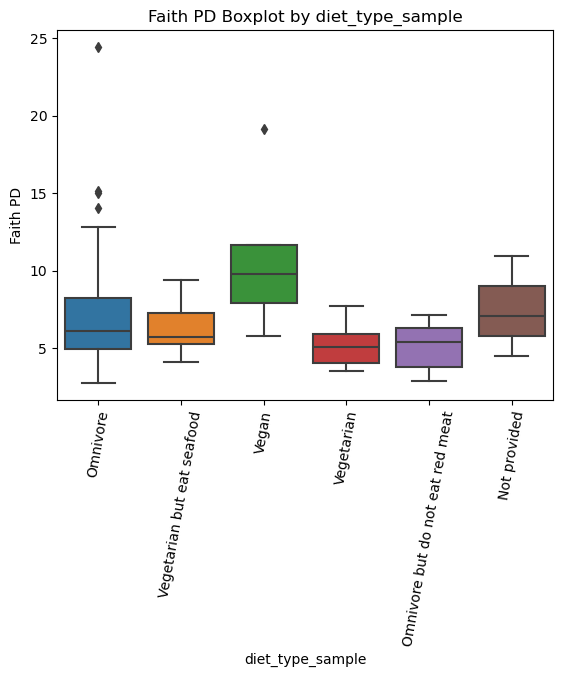

In [18]:
types = category_dropdown.value

div = q2.Artifact.load('./data/core-metrics-results/faith_pd_vector.qza').view(pd.Series)
md = pd.read_csv('./data/fungut_metadata.tsv', sep='\t', index_col=0)[f'{types}_sample']
# Concatenate the series that we provided
dd = pd.concat([div, md], axis=1, join='inner')

# make a boxplot with Faith PD on the y-axis and the selected 'type' on the x-axis (hint: look at the "by" parameter)
sns.boxplot(x=f'{types}_sample', y = dd.columns[0], data = dd)
plt.xlabel(f'{types}_sample')
plt.xticks(rotation = 80)
plt.ylabel('Faith PD')
plt.title(f'Faith PD Boxplot by {types}_sample')
plt.show()